In [1]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
import seaborn as sns
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Base

* Base focada na previsao do valor médio de casas para os distritos da Califórnia
* Variavel resposta: MedHouseVal
* Demais variaveis serão utilizadas como preditivas

In [2]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Construindo o modelo Random Forest

In [4]:
# Separar variáveis independentes e dependentes
X = df.drop(columns=['MedHouseVal'])  # 'MedHouseVal' é a variável resposta
y = df['MedHouseVal']

In [5]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Otimização de Hiperparâmetros com Optuna usando Cross-Validation
def objective(trial):
    # Definir hiperparâmetros a serem otimizados
    max_depth = trial.suggest_int("max_depth", 2, 20, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

    # Criar o modelo
    rf = RandomForestRegressor(
        n_estimators=1000,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Configurar validação cruzada com semente fixa
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Usar Cross-Validation para calcular o erro médio
    cv_scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    
    # Retornar a média do erro quadrático médio
    return -cv_scores.mean()

# Criar e executar o estudo
study = optuna.create_study(direction="minimize",sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20, n_jobs=-1)

# Exibir os melhores hiperparâmetros
print("Melhores Hiperparâmetros:\n", study.best_params)

[I 2025-01-16 00:26:27,840] A new study created in memory with name: no-name-2b9e9f9d-1221-4d4b-8302-08333ca9f991
[I 2025-01-16 00:28:36,642] Trial 2 finished with value: 0.7156460364724347 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7156460364724347.
[I 2025-01-16 00:28:37,045] Trial 7 finished with value: 0.7156460364724347 and parameters: {'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7156460364724347.
[I 2025-01-16 00:28:38,141] Trial 9 finished with value: 0.7156460364724347 and parameters: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7156460364724347.
[I 2025-01-16 00:30:34,713] Trial 6 finished with value: 0.5110945872645926 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.5110945872645926.
[I 2025-01-16 00:32:34,293] Trial 11 finished with value: 0.39851

Melhores Hiperparâmetros:
 {'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2}


In [7]:
# Reavaliando com os melhores hiperparâmetros
best_params = study.best_params
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"MSE com Melhor Modelo: {mse_best:.2f}")
print(f"R² Score com Melhor Modelo: {r2_best:.2f}")

MSE com Melhor Modelo: 0.26
R² Score com Melhor Modelo: 0.80


In [8]:
# salvando o modelo
import joblib
joblib.dump(best_rf, "random_forest_model.pkl")

['random_forest_model.pkl']

# Testes de Estabilidades

### Erro ao longo de Y

In [9]:
# Divide a variável de resposta em quantis
quantiles = pd.qcut(y_test, q=8, labels=False)  # Divide em 8 quantis (ajuste o `q` conforme necessário)

# Calcula os erros para cada quantil
results = pd.DataFrame({
    'y_true': y_test,       # Valores reais de y
    'y_pred': y_pred_best,  # Valores previstos de y
    'quantile': quantiles   # Quantil correspondente
})
results['error'] = (results['y_true'] - results['y_pred'])**2  # Erro quadrático

# Agrega estatísticas para cada quantil
quantile_stats = results.groupby('quantile').agg(
    mse=('error', lambda x: np.mean(x)),       # Média dos erros quadráticos (MSE)
    std_error=('error', lambda x: np.std(x))  # Desvio padrão dos erros
).reset_index()

# Exibe os resultados
print(quantile_stats)

   quantile       mse  std_error
0         0  0.146320   0.621497
1         1  0.106839   0.275610
2         2  0.145938   0.516124
3         3  0.142992   0.451453
4         4  0.150135   0.437833
5         5  0.198317   0.419506
6         6  0.286016   0.483802
7         7  0.892368   1.497521


### Diferentes bases de teste - Usando bootstraping

In [15]:
# Configura uma semente aleatória para reprodutibilidade
random_seed = 42
np.random.seed(random_seed)

# Número de amostras bootstrap (300 novas bases)
n_bootstrap_samples = 300

# Lista para armazenar as pontuações de MSE
bootstrap_mse_scores = []

# Realiza o processo de bootstrapping
for i in range(n_bootstrap_samples):
    # Gera uma amostra bootstrap (com reposição)
    bootstrap_indices = np.random.choice(len(X_test), size=len(X_test), replace=True)
    
    # Usa os índices bootstrap para selecionar os dados e converter para NumPy
    X_bootstrap = X_test.iloc[bootstrap_indices].values
    y_bootstrap = y_test.iloc[bootstrap_indices].values

    # Faz previsões na amostra bootstrap
    y_pred = best_rf.predict(X_bootstrap)

    # Calcula o erro médio quadrático (MSE) e o armazena
    mse = mean_squared_error(y_bootstrap, y_pred)
    bootstrap_mse_scores.append(mse)

# Estatísticas resumidas
mean_mse = np.mean(bootstrap_mse_scores)  # Média dos MSEs
std_mse = np.std(bootstrap_mse_scores)    # Desvio padrão dos MSEs

# Exibe os resultados
print(f"Resultados do Bootstrap MSE:")
print(f"Média do MSE: {mean_mse:.4f}")
print(f"Desvio padrão: {std_mse:.4f}")

Resultados do Bootstrap MSE:
Média do MSE: 0.2564
Desvio padrão: 0.0113


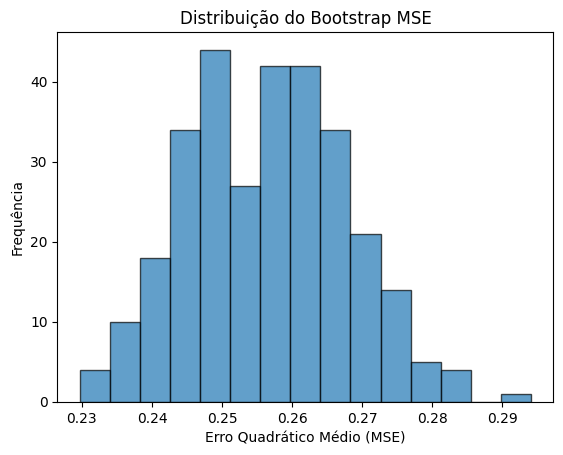

In [20]:
# Opcional: Visualizar os resultados
import matplotlib.pyplot as plt

plt.hist(bootstrap_mse_scores, bins=15, edgecolor='k', alpha=0.7)  # Cria o histograma
plt.title("Distribuição do Bootstrap MSE")  # Título do gráfico
plt.xlabel("Erro Quadrático Médio (MSE)")    # Rótulo do eixo X
plt.ylabel("Frequência")                     # Rótulo do eixo Y
plt.show()                                   # Exibe o gráfico

### Impacto de cada variável no erro - Randomizando as variaveis

In [19]:
# Configura uma semente aleatória para reprodutibilidade
random_seed = 42
np.random.seed(random_seed)

# Inicializa um contêiner para armazenar os resultados de desempenho
feature_mse = []

# Itera sobre cada feature (coluna)
for feature in X_test.columns:
    # Cria uma cópia de X_test
    X_test_modified = X_test.copy()
    
    # Substitui a feature atual por valores aleatórios
    X_test_modified[feature] = np.random.permutation(X_test[feature])
    
    # Avalia o modelo no conjunto de dados modificado
    y_pred = best_rf.predict(X_test_modified)
    mse = mean_squared_error(y_test, y_pred)
    feature_mse.append(mse)
    print(f"{feature} - MSE: {mse:.4f}")

MedInc - MSE: 1.2398
HouseAge - MSE: 0.3580
AveRooms - MSE: 0.2922
AveBedrms - MSE: 0.2677
Population - MSE: 0.2642
AveOccup - MSE: 0.5375
Latitude - MSE: 0.8220
Longitude - MSE: 0.6789
